<a href="https://colab.research.google.com/github/UNIST-LIM-Lab-course/distributed-learning-assignment-xiyanafiguera/blob/main/ray_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Distributed Learning Assignment

--------

- This assignment is due on **Nov. 20 (11:59 PM)** - LATE SUBMISSION WILL NOT BE ACCEPTED
- Please **carefully follow the instructions** for each assignment.

### Grading criteria
1. All the codes in this notebook should be runnable.
2. FInal test model accuracy should be over 50%.  

Total 7 points will be given if and only if the two criteria are satisfied.  

# Ray

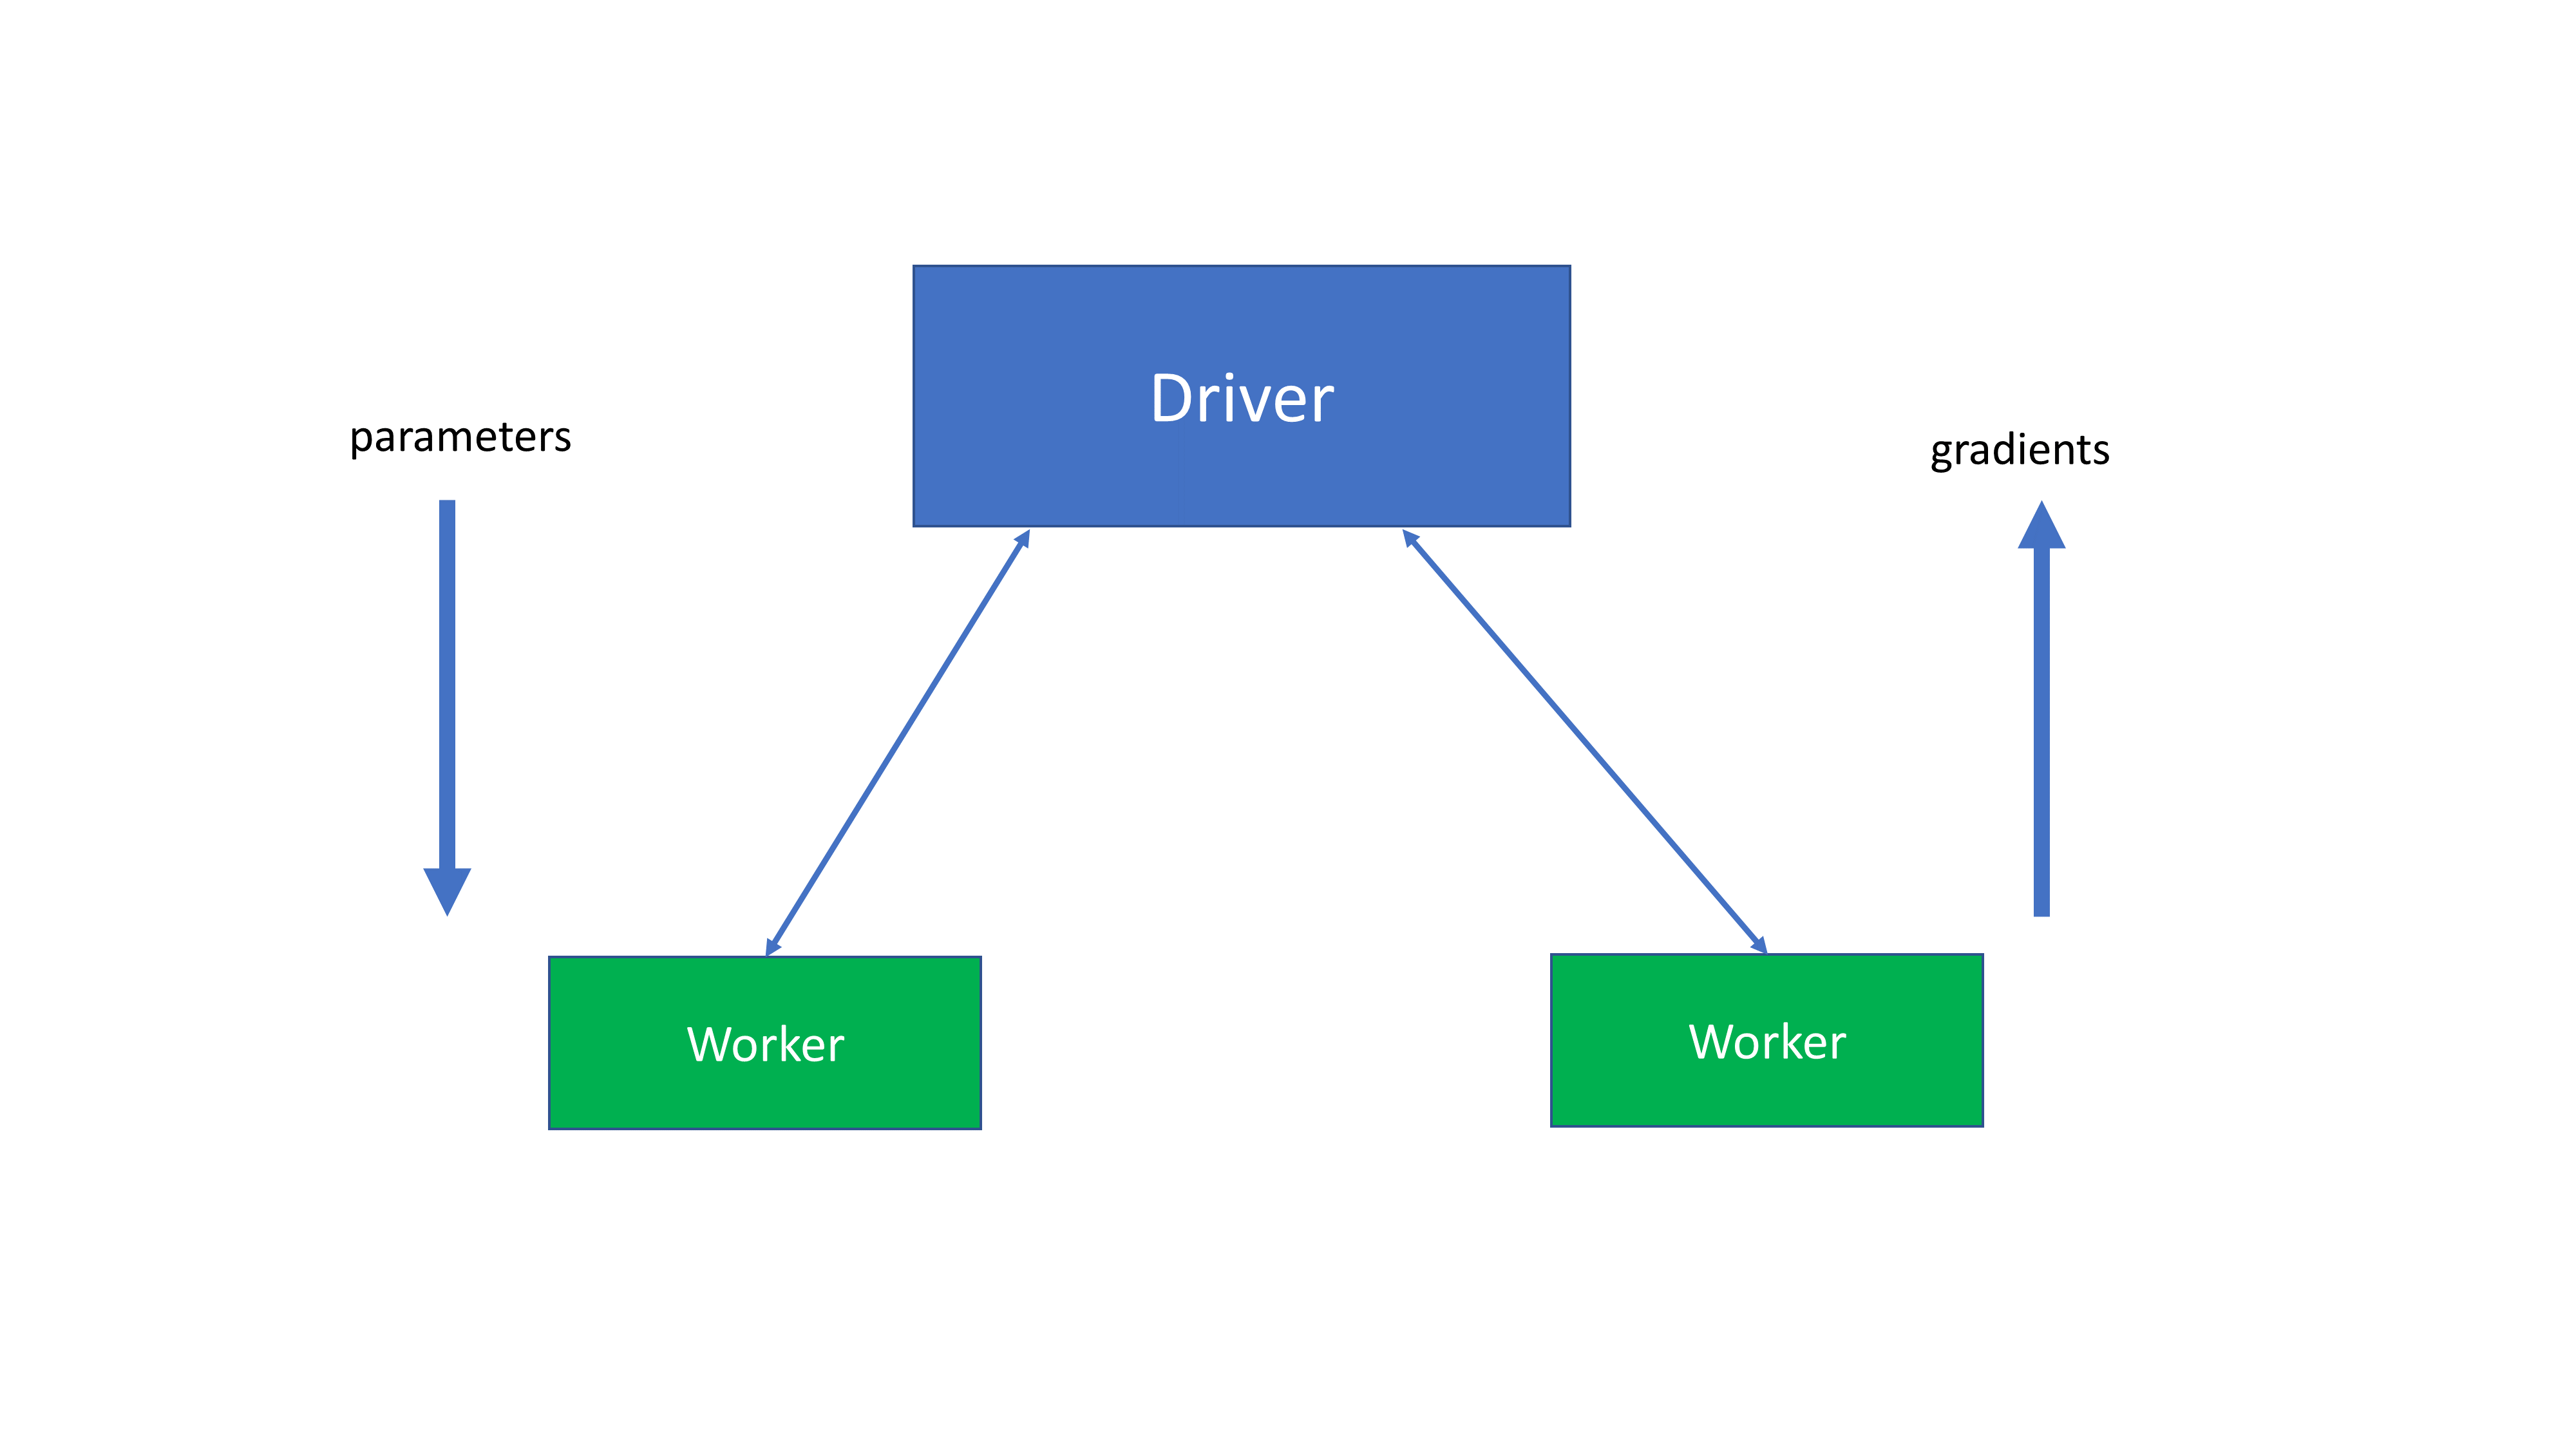

The task objective is to implement an asynchronous distributed learning using ray.  
In this assignment, you are required to fill in the TODO part.  

Install ray 

In [1]:
!pip install ray[default]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59.1 MB 1.2 MB/s 
     |████████████████████████████████| 8.8 MB 30.0 MB/s 
     |████████████████████████████████| 90 kB 9.2 MB/s 
     |████████████████████████████████| 128 kB 63.2 MB/s 
     |████████████████████████████████| 57 kB 5.2 MB/s 
     |████████████████████████████████| 201 kB 57.7 MB/s 
     |████████████████████████████████| 3.0 MB 37.5 MB/s 
     |████████████████████████████████| 280 kB 66.7 MB/s 
     |████████████████████████████████| 58 kB 6.0 MB/s 
     |████████████████████████████████| 468 kB 58.0 MB/s 
  Created wheel for gpustat: filename=gpustat-1.0.0-py3-none-any.whl size=19887 sha256=df72f79e26cf750a68f94a40725c523ff8427164ab44b0b2f40aa935b8b0f223
  Stored in directory: /root/.cache/pip/wheels/d2/31/5c/eb69af6e2285e7d6ec8d7dc26435be7c81c6ad22c45efdcca7
Successfully built gpustat
  Attempting uninstall: psutil
    Found 

Import necessary modules

In [2]:
import ray
import os
import time
import sys 
import numpy as np 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from filelock import FileLock

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

Define a simple convolutional network.  
In this model, we need to implement getter/setter member functions for parameters and gradients for drivier-worker communication.  

In [3]:
class CNN(nn.Module):
    """Small CNN"""

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    # to get parameters of the model
    def get_parameters(self):
        return {k: v.cpu() for k, v in self.state_dict().items()}

    # to set parameters of the model given the weights
    def set_parameters(self, weights):
        self.load_state_dict(weights)

    # to get gradients of the model
    def get_gradients(self):
        grads = []
        for p in self.parameters():
            grad = None if p.grad is None else p.grad.data.cpu().numpy()
            grads.append(grad)
        return grads

    # to set gradients of the model given the gradients
    def set_gradients(self, gradients):
        for g, p in zip(gradients, self.parameters()):
            if g is not None:
                p.grad = torch.from_numpy(g)

Define helper class and functions to load data and evaluate.  

In [4]:
class WorkerTrainMNISTData(object):

    def __init__(self, worker_id): 
        self.train_loader = None
        self.worker_id = worker_id
        self.g = torch.Generator()
        self.g.manual_seed(0)

    # MNIST dataset should be downloaded by calling get_test_data_loader function
    # prior to calling this function
    def prepare_data(self):
        train_dataset = list(datasets.MNIST(
                "~/data", train=True, download=False, transform=transforms.ToTensor()
                ))[self.worker_id::2]
        self.train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=128,
            shuffle=True,
            generator=self.g
        )

    def get_dataloader(self):
        """get dataloader"""
        return self.train_loader

def get_test_data_loader():
    """download and get test dataloader."""
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST("~/data", train=False, download=True, transform=transforms.ToTensor()),
        batch_size=128,
        shuffle=False,
    )
    return test_loader



def evaluate(model, test_loader):
    """evaluates the accuracy of the model"""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # This is only set to finish evaluation faster.
            if batch_idx * len(data) > 1024:
                break
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100.0 * correct / total

Define a driver class.  
In the driver class, there are two members: the CNN model and the optimizer.  
The driver's role is to:  
1. aggregate the gradients delivered from the workers,
2. optimize the model's parameters with the aggregated gradients, and
3. send the updated parameters back to the workers.  


In [5]:
@ray.remote
class Driver(object):

    def __init__(self, lr):
        self.model = CNN()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
    
    # to aggregate gradients obtained from the workers
    def aggregate_gradients(self, *gradients):
        summed_gradients = [
            np.stack(gradient_zip).sum(axis=0) for gradient_zip in zip(*gradients)
        ]
        self.optimizer.zero_grad()
        self.model.set_gradients(summed_gradients)
        self.optimizer.step()
        #return self.model.get_weights()

    # to get parameters of the model
    def get_parameters(self):
        return self.model.get_parameters()

Define a worker class.  
There is also a CNN model in the worker.  
The role of the worker is to:  
1. copy the parameters of the central model from the driver,
2. compute the gradients given the data and the label, and 
3. send the computed gradients to the driver.  


In [6]:
@ray.remote(num_gpus=0.5 if torch.cuda.is_available() else 0)
class Worker(object):
    def __init__(self, id):
        self.model = CNN().to(device)
        self.id = id
        self.data_generator = WorkerTrainMNISTData(worker_id=id)
        self.data_generator.prepare_data()
        self.data_iterator = iter(self.data_generator.get_dataloader())
    
    # copy the central driver's parameters to the worker model and compute gradients 
    def compute_gradients(self, weights):
        self.model.set_parameters(weights)
        try:
            data, target = next(self.data_iterator)
        except StopIteration:  # When the epoch ends, start a new epoch.
            self.data_generator = WorkerTrainMNISTData(worker_id=self.id)
            self.data_generator.prepare_data()
            self.data_iterator = iter(self.data_generator.get_dataloader())
            data, target = next(self.data_iterator)
        self.model.zero_grad()
        output = self.model(data.to(device))
        loss = F.nll_loss(output, target.to(device))
        loss.backward()
        return self.model.get_gradients()

## Asynchronous distributed training (TODO)

Instantiate a tester model and a test set.  

In [7]:
tester_model = CNN()
test_loader = get_test_data_loader()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/train-images-idx3-ubyte.gz to /root/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/MNIST/raw



Start ray, instantiate the driver and the workers.  

In [8]:
ray.init(ignore_reinit_error=True)
num_workers = 2
driver = Driver.remote(lr=1e-2)
workers = [Worker.remote(id=i) for i in range(num_workers)]

2022-11-19 05:05:44,717	INFO worker.py:1525 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


###Train the model in the driver by using the gradients computed by the distributed workers. (TODO)   
Fill in the TODO part in the code below.  
__Caution: Do not change the number of workers and iterations.__ 


In [9]:
current_parameters = driver.get_parameters.remote()
iterations = 10

gradients = {}

# initialize the gradients dictionary
# the gradients dictionary serves as a task queue to compute gradients
for worker in workers:
    gradients[worker.compute_gradients.remote(current_parameters)] = worker

for i in range(iterations * num_workers):
    ####### TODO ####### 
    # 1. identify the ready gradients
    # 2. pop out and get worker that already computed gradients
    # 3. apply the ready worker's gradients to the central driver's model
    # 4. obtain the driver's model parameters
    # 5. re-insert the used worker to the gradient task queue
    #####################
    ready_gradients_list, _ = ray.wait(list(gradients))
    ready_gradients_id = ready_gradients_list[0]

    worker = gradients.pop(ready_gradients_id)
    driver.aggregate_gradients.remote(ready_gradients_id)

    current_parameters = driver.get_parameters.remote()

    gradients[worker.compute_gradients.remote(current_parameters)] = worker
    
    # evaluate the current model
    tester_model.set_parameters(ray.get(current_parameters))
    accuracy = evaluate(tester_model, test_loader)
    print("Iter {}: \taccuracy is {:.1f}".format(i, accuracy))

Iter 0: 	accuracy is 14.0
Iter 1: 	accuracy is 16.9
Iter 2: 	accuracy is 10.7
Iter 3: 	accuracy is 17.3
Iter 4: 	accuracy is 21.1
Iter 5: 	accuracy is 32.9
Iter 6: 	accuracy is 38.8
Iter 7: 	accuracy is 41.1
Iter 8: 	accuracy is 44.4
Iter 9: 	accuracy is 45.8
Iter 10: 	accuracy is 49.4
Iter 11: 	accuracy is 53.6
Iter 12: 	accuracy is 56.4
Iter 13: 	accuracy is 60.8
Iter 14: 	accuracy is 63.7
Iter 15: 	accuracy is 65.9
Iter 16: 	accuracy is 69.4
Iter 17: 	accuracy is 71.4
Iter 18: 	accuracy is 72.2
Iter 19: 	accuracy is 73.4


# Testing: DO NOT EDIT THE CELLS BELOW AND DO NOT ADD CELLS BELOW

### Ray

In [10]:
print(evaluate(tester_model, test_loader))

73.35069444444444


In [11]:
# THIS CELL IS INTENTIONALLY LEFT AS BLANK.